### eBird Status and Trends API

Refer to API docs: https://ebird.github.io/ebirdst/articles/api.html


## 1. Imports

Imports for API calls, date handling, data processing, and mapping (for raster data).

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import os
import requests
from dotenv import load_dotenv
from datetime import datetime, timedelta
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import rasterio
from rasterio.mask import mask
from rasterio.plot import show

from bird_groups import *

## 2. Get Taxonomy (Status and Trends API)

Before using this endpoint, I need to get a list of eBird species code names for the 74 different species in my `flattened_species` list.

In [ ]:
def get_taxonomy():
	'''
	Helper to get the taxonomy dataset, which includes sciName, comName, speciesCode, etc.
	'''
	standard_api_key = os.getenv("EBIRD_STD_API_KEY")
	headers = {'X-eBirdApiToken':standard_api_key}

	url = f"https://api.ebird.org/v2/ref/taxonomy/ebird?fmt=json"

	response = requests.get(url, headers=headers, timeout=60)

	if response.status_code == 200:
		taxonomy = response.json()
		return pd.DataFrame(taxonomy)
	else:
		print(f"Failed ({response.status_code})")
		return []
      
def get_species_codes() -> pd.DataFrame:
	'''
	Returns dataframe with common species name, species code, and appropriate species group.
	'''
	
	tax = get_taxonomy()
	tax["comName_norm"] = tax["comName"].apply(_norm)
	tax["speciesGroup"] = tax["comName_norm"].apply(get_group_for_species)
	in_groups = tax[["comName_norm","speciesCode","speciesGroup"]]
	
	return in_groups[in_groups["speciesGroup"] != "NOT_IN_GROUPS"].reset_index(drop=True)

# Build lookup dictionary once: species -> species code
_species_code_to_name = {row.speciesCode: row.comName_norm 
                         for row in get_species_codes().itertuples()}

The function below runs once to define the lookup dictionary and prevent re-running in the future.

In [ ]:
# _species_code_to_name

{'snogoo': 'snow goose',
 'rosgoo': "ross's goose",
 'gwfgoo': 'greater white-fronted goose',
 'brant': 'brant',
 'cangoo': 'canada goose',
 'rebgoo1': 'red-breasted goose',
 'mutswa': 'mute swan',
 'blkswa': 'black swan',
 'truswa': 'trumpeter swan',
 'tunswa': 'tundra swan',
 'wooduc': 'wood duck',
 'buwtea': 'blue-winged teal',
 'norsho': 'northern shoveler',
 'gadwal': 'gadwall',
 'amewig': 'american wigeon',
 'mallar3': 'mallard',
 'ambduc': 'american black duck',
 'y00600': 'mallard/american black duck',
 'norpin': 'northern pintail',
 'gnwtea': 'green-winged teal',
 'canvas': 'canvasback',
 'redhea': 'redhead',
 'rinduc': 'ring-necked duck',
 'gresca': 'greater scaup',
 'lessca': 'lesser scaup',
 'whwsco2': 'white-winged scoter',
 'lotduc': 'long-tailed duck',
 'buffle': 'bufflehead',
 'comgol': 'common goldeneye',
 'rudduc': 'ruddy duck',
 'rocpig': 'rock pigeon',
 'y00475': 'american coot',
 'sancra': 'sandhill crane',
 'whocra': 'whooping crane',
 'ribgul': 'ring-billed gull'

## 3. Available Files from Status and Trends 

Identifying which types of files are available to download from the API.

Using the following endpoint:   
https://st-download.ebird.org/v1/list-obj/{version_year}/{species_code}?key={access_key} 

In [89]:
load_dotenv()
standard_api_key = os.getenv("EBIRD_STD_API_KEY")
headers = {'X-eBirdApiToken':standard_api_key}
url = f"https://st-download.ebird.org/v1/list-obj/2023/woothr?key={standard_api_key}"

response = requests.get(url, headers=headers, timeout=60)
possible_downloads = pd.DataFrame(response.json())
possible_downloads = possible_downloads.rename(columns={possible_downloads.columns[0]:"path"})

endings = possible_downloads["path"].str.split(".").str[-1].unique()
endings

array(['json', 'csv', 'tif', 'gpkg', 'zip'], dtype=object)

In [90]:
def get_file_types(ftype: str) -> list: 
	'''
	available filetypes: ['json', 'csv', 'tif', 'gpkg', 'zip']\n
	example: ftype of ".csv" returns all download paths for .csv Status and Trends files. 
	'''
	load_dotenv()
	standard_api_key = os.getenv("EBIRD_STD_API_KEY")
	headers = {'X-eBirdApiToken':standard_api_key}
	url = f"https://st-download.ebird.org/v1/list-obj/2023/woothr?key={standard_api_key}"

	response = requests.get(url, headers=headers, timeout=60)
	possible_downloads = pd.DataFrame(response.json())
	possible_downloads = possible_downloads.rename(columns={possible_downloads.columns[0]:"path"})

	filter_download = possible_downloads[possible_downloads["path"].str.contains(ftype)]
	return list(filter_download["path"])

In [91]:
get_file_types(".csv")

['2023/woothr/pis/pi_rangewide.csv',
 '2023/woothr/regional_stats.csv',
 '2023/woothr/weekly/band-dates.csv',
 '2023/woothr/weekly/woothr_centroids.csv']

Suspected tif file to download is 
**"Median Abundance Raster (All Weeks)"** which shows up as "2023/woothr/web_download/weekly/woothr_abundance_median_{year}-{month}-{day}.tif" 

## 4. Mapping Raster Data and Masking for Illinois

Saved TIFF successfully
(5562, 11484)
EPSG:8857
BoundingBox(left=-17226000.0, bottom=-8343000.0, right=17226000.0, top=8343000.0)


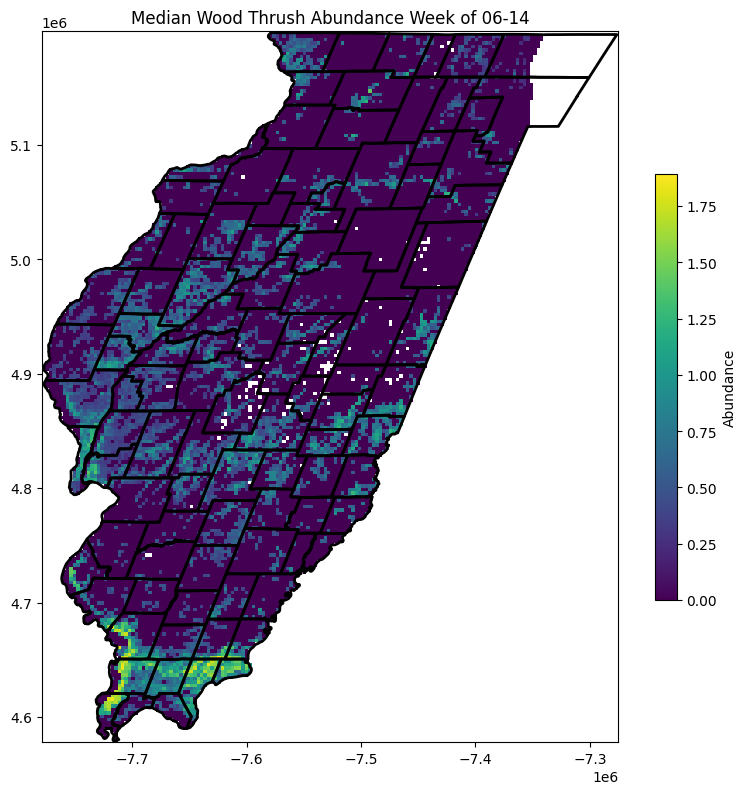

In [ ]:
# playing around with the tiff data:

standard_api_key = os.getenv("EBIRD_STD_API_KEY")
headers = {'X-eBirdApiToken':standard_api_key}

object_path = "2023/woothr/web_download/weekly/woothr_abundance_median_2023-06-14.tif"
url = f"https://st-download.ebird.org/v1/fetch?objKey={object_path}&key={standard_api_key}"

response = requests.get(url, headers=headers, timeout=60)

test_tiff_path = Path("tiff_cache/")
curr_species_and_week = "woothr_2023-01-04.tif"

if response.status_code == 200:
	with open(test_tiff_path / curr_species_and_week, "wb") as f:
		f.write(response.content)
	# Saved TIFF successfully
else:
	print("Failed:", response.status_code)

with rasterio.open(test_tiff_path / curr_species_and_week) as src:
	data = src.read(1)
	print(data.shape)
	print(src.crs)
	print(src.bounds)

# UPDATED MASKING CODE
us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
il = us_states[us_states["STATEFP"]=="17"]

with rasterio.open(test_tiff_path / curr_species_and_week) as src:
	il = il.to_crs(src.crs)
	
	out_image, out_transform = mask(src, il.geometry, crop=True, filled=False)
	out_meta = src.meta.copy()
	
	# Update metadata
	out_meta.update({
		"height": out_image.shape[1],
		"width": out_image.shape[2],
		"transform": out_transform,
		"nodata": -9999
	})

# Write with proper nodata handling
new_path = "woothr_2023-01-04_ILLINOIS.tif"
with rasterio.open(new_path, "w", **out_meta) as dest:
    dest.write(out_image.filled(-9999))

with rasterio.open(new_path) as src:
	data = src.read(1, masked=True)
	
	fig, ax = plt.subplots(figsize=(8, 8))
	
	im = ax.imshow(data, 
	# this is  important to correctly plot illinois boundary
	extent = [src.bounds.left, src.bounds.right, 
						src.bounds.bottom, src.bounds.top],
	cmap='viridis')
	
	il.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
	
	ax.set_title("Median Wood Thrush Abundance Week of 06-14")
	plt.colorbar(im, ax=ax, label="Abundance", shrink=0.6)
	plt.tight_layout()
	plt.show()

## 5. Final Script for All 74 Species:  
* Return 15 maps which represent all species in a group for Illinois on any given week of the year.

In [97]:
def get_common_name(species_code: str) -> str:
	return spcscode_to_comname.get(species_code, "group_na")

In [103]:
test_cangoo = get_common_name("cangoo")
test_cangoo

NameError: name 'spcscode_to_comname' is not defined

In [ ]:
def get_single_tif(week_of: str, species: str, headers: dict):
	'''
	Handle single request for species data (standard dataset).\n
	`week_of` entered as "mm-dd-yy"\n
	`species` should be entered as an eBird speciesCode.\n
	organizes like this:\n
	tiff_cache folder -> week_of subfolder -> 15 species group subfolders -> species
	'''
	dt_week_of = datetime.strptime(week_of, "%m-%d-%y")
	beginning = datetime.strptime("01-04-23", "%m-%d-%y")
	delta_days = (dt_week_of - beginning).days
	weeks = delta_days // 7
	corrected_week_str = (beginning + timedelta(days = weeks*7)).strftime("%m-%d-%y")
	# snip until the mm-dd part 01-04-23 -> 01-04
	corrected_week_str = corrected_week_str[:5]

	load_dotenv()
	standard_api_key = os.getenv("EBIRD_STD_API_KEY")

	# 2023 version is something constant, can add a feature to change this if needed
	object_path = f"2023/{species}/web_download/weekly/{species}_abundance_median_2023-{corrected_week_str}.tif"
	url = f"https://st-download.ebird.org/v1/fetch?objKey={object_path}&key={standard_api_key}"
	
	# remember to run the flat dict section cell to define species_to_group_norm
	com_name = get_common_name(species)
	s_group = species_to_group_norm.get(com_name, "group not found")
	cache_dir = Path(f"tiff_cache") / corrected_week_str / str(s_group)
	cache_dir.mkdir(parents=True, exist_ok=True)

	curr_tif_path = cache_dir / f"{species}_v2023-{corrected_week_str}.tif"
	
	if curr_tif_path.exists():
		with open(curr_tif_path, "rb") as f:
			return f.read()
		
	response = requests.get(url, headers=headers, timeout=60)
		
	if response.status_code == 200:
		with open(curr_tif_path, "wb") as f:
			f.write(response.content)
		return response.content
	elif response.status_code == 500:
		# 500 usually means no data available for this species/week
		return (species, com_name, "no_data", None)
	else:
		print(f"Failed ({species}) - Status: {response.status_code}, URL: {url[:-20]}/...")
		# returns an empty byte
		return b""

def get_tif_all_species(week_of: str, species_codes: list):
	# this will populate the cache, so i can iterate over it in a separate function
	load_dotenv()
	api_key = os.getenv("EBIRD_API_KEY")
	headers = {'X-eBirdApiToken':api_key}

	with ThreadPoolExecutor(max_workers=4) as executor:
		futures = [executor.submit(get_single_tif, week_of, s, headers) for s in species_codes]
		for fut in as_completed(futures):
			# not much to handle here since it gets cached instead
			try:
				fut.result()
			except Exception as e:
				print(f"error downloading species: {e}")

	return "Finished"

In [ ]:
get_tif_all_species("1-04-23")

'Finished'

Note: the fallback on the above function returns None for species that were not found for the specified week. 

For example, in testing I identified the following to not be found: rebgoo1, y00600, easowl1, grhowl. These were excluded in the final data for that week.

Now I can move on to plotting the species.

In [ ]:
def get_grouped_tif_data(week_of: str) -> dict:
	'''
	Get a dictionary mapping species to windows path to its species, using the tif data generated by `get_tif_all_species().`\n
	`week_of` -> which week to create the map for.\n
	'''
	dt_week_of = datetime.strptime(week_of, "%m-%d-%y")
	beginning = datetime.strptime("01-04-23", "%m-%d-%y")
	delta_days = (dt_week_of - beginning).days
	weeks = delta_days // 7
	corrected_week_str = (beginning + timedelta(days = weeks*7)).strftime("%m-%d-%y")
	
	subfolder_date = corrected_week_str[:5]
	week_dir = Path("tiff_cache") / subfolder_date
	
	if not week_dir.exists():
		print("no data found for given date")
		return {}
	
	groups_data = {}
	for group_dir in sorted(week_dir.iterdir()):
		if group_dir.is_dir():
			group_name = group_dir.name
			tif_files = list(group_dir.glob("*.tif"))

			if tif_files:
				groups_data[group_name] = tif_files

	return groups_data


In [ ]:
test_dict = get_grouped_tif_data("01-04-23")
print(test_dict.keys())
print("")
print(test_dict.values())

dict_keys(['Cranes', 'Dabbling Ducks', 'Diving Ducks', 'Geese', 'Grebes', 'Gulls & Terns', 'Herons & Egrets', 'Owls', 'Passerines', 'Pelicans & Cormorants', 'Pigeons & Coots', 'Raptors (Falcons)', 'Raptors (Hawks & Eagles)', 'Swans', 'Vultures'])

dict_values([[WindowsPath('tiff_cache/01-04/Cranes/sancra_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Cranes/whocra_v2023-01-04.tif')], [WindowsPath('tiff_cache/01-04/Dabbling Ducks/ambduc_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/amewig_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/buwtea_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/gadwal_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/gnwtea_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/mallar3_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/norpin_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Ducks/norsho_v2023-01-04.tif'), WindowsPath('tiff_cache/01-04/Dabbling Du

In [ ]:
def create_maps_from_tifs(week_of: str):
	dt_week_of = datetime.strptime(week_of, "%m-%d-%y")
	beginning = datetime.strptime("01-04-23", "%m-%d-%y")
	delta_days = (dt_week_of - beginning).days
	weeks = delta_days // 7
	corrected_week_str = (beginning + timedelta(days = weeks*7)).strftime("%m-%d-%y")

	grouped_tifs = get_grouped_tif_data(corrected_week_str)

	# for species group and its corresponding tif files..
	for s_group, tif_files in grouped_tifs.items():
		print(f"\nGenerating map for {s_group}")
		print(f"Species files: {[f.stem for f in tif_files]}")

		us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
		il = us_states[us_states["STATEFP"]=="17"]
		
		# Stack to accumulate abundance across all species in group
		combined_data = None
		bounds = None
		
		for tif_path in tif_files:
			with rasterio.open(tif_path) as src:
				il_proj = il.to_crs(src.crs)
				out_image, out_transform = mask(src, il_proj.geometry, crop=True, filled=False)
				
				# Mask nodata values
				data = np.ma.masked_equal(out_image[0].filled(-9999), -9999)
				
				# Initialize or add to combined data
				if combined_data is None:
					combined_data = data
					bounds = src.bounds
				else:
					combined_data = combined_data + data
					
		# plot outside inner loop
		fig, ax = plt.subplots(figsize=(8, 8))
		im = ax.imshow(combined_data,
			extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
			cmap='viridis')
		il.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
		ax.set_title(f"{s_group} - Combined Abundance", fontsize=14, fontweight='bold')
		plt.colorbar(im, ax=ax, label="Total Abundance", shrink=0.6)
		plt.tight_layout()
		# plt.show()

		# path to save to
		output_path = Path(f"tif_maps/{corrected_week_str[:5]}_maps")
		output_path.mkdir(parents=True, exist_ok=True)

		# save this current graph
		plt.savefig(output_path / f"{s_group}.png")
		plt.close()

In [ ]:
create_maps_from_tifs("01-04-23")


Generating map for Cranes
Species files: ['sancra_v2023-01-04', 'whocra_v2023-01-04']

Generating map for Dabbling Ducks
Species files: ['ambduc_v2023-01-04', 'amewig_v2023-01-04', 'buwtea_v2023-01-04', 'gadwal_v2023-01-04', 'gnwtea_v2023-01-04', 'mallar3_v2023-01-04', 'norpin_v2023-01-04', 'norsho_v2023-01-04', 'wooduc_v2023-01-04']

Generating map for Diving Ducks
Species files: ['buffle_v2023-01-04', 'canvas_v2023-01-04', 'comgol_v2023-01-04', 'gresca_v2023-01-04', 'lessca_v2023-01-04', 'lotduc_v2023-01-04', 'redhea_v2023-01-04', 'rinduc_v2023-01-04', 'rudduc_v2023-01-04', 'whwsco2_v2023-01-04']

Generating map for Geese
Species files: ['brant_v2023-01-04', 'cangoo_v2023-01-04', 'gwfgoo_v2023-01-04', 'rosgoo_v2023-01-04', 'snogoo_v2023-01-04']

Generating map for Grebes
Species files: ['eargre_v2023-01-04', 'pibgre_v2023-01-04']

Generating map for Gulls & Terns
Species files: ['amhgul1_v2023-01-04', 'caster1_v2023-01-04', 'comter_v2023-01-04', 'ribgul_v2023-01-04']

Generating map